# ***Riya Garg***
# ***Legal Bert for Legal dataset***
# *CS646 Poject*

In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

## ***Step 1:*** Download Dataset and Tranformers library

In [ ]:
%%capture
! pip install datasets transformers

## ***Step 2:*** Mount drive for dataset access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Step 3:*** Check the data

In [ ]:
import json
from pathlib import Path
import re

def targeted_clean_sentences(sent_list):
    """
    Remove sentences containing JavaScript or irrelevant patterns.
    """
    unwanted_patterns = [
        r"var ", r"s_context", r"\$", r"require", r"function", r"insert", r"webmd", r"disable", r"ads", r"module"
    ]
    # Compile regex for unwanted patterns
    unwanted_regex = re.compile("|".join(unwanted_patterns), re.IGNORECASE)

    # Filter out sentences matching unwanted patterns
    clean_sent_list = [sentence for sentence in sent_list if not unwanted_regex.search(sentence)]
    return " ".join(clean_sent_list)  # Join the cleaned sentences

def load_and_preprocess_data_with_targeted_cleaning(file_path):

    with open(file_path, 'r') as f:
        legal_data = json.load(f)

    texts, queries, answers = [], [], []

    # Search for each passage, its question, and its answer
    for entry in legal_data["data"]:
        context = entry["context"]
        question = entry["question"]
        answer_start = int(entry["answer"]["answer_start"])
        answer_end = int(entry["answer"]["answer_end"])
        answer_text = context[answer_start:answer_end+1]

        # Store each passage, query, and answer into the lists
        texts.append(context)
        queries.append(question)
        answers.append({"text": answer_text, "answer_start": answer_start, "answer_end": answer_end})

    return texts, queries, answers

# Process train data
train_path = Path('/content/drive/MyDrive/646 Project/Legal/train_dataset.json')
train_texts, train_queries, train_answers = load_and_preprocess_data_with_targeted_cleaning(train_path)

# Process validation data
val_path = Path('/content/drive/MyDrive/646 Project/Legal/validate_dataset.json')
val_texts, val_queries, val_answers = load_and_preprocess_data_with_targeted_cleaning(val_path)


In [ ]:
print("Passage: ",train_texts[0][418:439])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

print("Passage: ",train_texts[1][105:110])
print("Query: ",train_queries[1])
print("Answer: ",train_answers[1])

Passage:  culpable mental state
Query:  In this section, what includes intention, motive or knowledge of a fact or belief in, or reason to believe a fact?
Answer:  {'text': 'culpable mental state', 'answer_start': 418, 'answer_end': 438}
Passage:  A-B=C
Query:  What is the amount charged to tax if the value of the asset in the year 2017-18 is one crore rupees?
Answer:  {'text': 'A-B=C', 'answer_start': 105, 'answer_end': 109}


As you can see we have 20302 passages, queries and answers from the validation data

In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

228
228
228


In [ ]:
print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  Repeal and savings.- (1) The following enactments are hereby repealed-  (a) the Metal Tokens Act, 1889 (1 of 1889); (b) the Coinage Act, 1906 (3 of 1906); (c) the Bronze Coin (Legal Tender) Act, 1918 (22 of 1918); (d) the Currency Ordinance, 1940 (Ord. IV of 1940); (e) the Small Coins (Offences) Act, 1971 (52 of 1971). (2) The repeal by this Act of the enactments and Ordinance specified in sub-section (1) shall not-  (a) affect any other enactment in which the repealed enactment or Ordinance has been applied, incorporated or referred to; (b) affect the validity, invalidity, effect or consequences of anything already done or suffered, or any right, title, obligation or liability already acquired, accrued or incurred or any remedy or proceeding in respect thereof, or any release or discharge of or from any debt, penalty, obligation, liability, claim or demand, or any indemnity already granted, or the proof of any past act or thing; (c) affect any principle or rule of law, or es

This was helped me to split my dataset in order to run my notebook in my first attemps.

In [ ]:
# train_texts = train_texts[:10]
# train_queries = train_queries[:10]
# train_answers = train_answers[:10]

# val_texts = val_texts[:10]
# val_queries = val_queries[:10]
# val_answers = val_answers[:10]

In [ ]:
# print(len(train_texts))
# print(len(train_queries))
# print(len(train_answers))

In [ ]:
# print(len(val_texts))
# print(len(val_queries))
# print(len(val_answers))

## ***Step 4:*** Find the end position character

Find end position character in train data

In [ ]:
# for answer, text in zip(train_answers, train_texts):
#     # Get the real answer and start index (access the first element of the lists)
#     real_answer = answer['text'][0]  # Extract the first text from the list
#     start_idx = int(answer['answer_start'][0])  # Extract the first start index from the list

#     # Calculate the real end index
#     end_idx = start_idx + len(real_answer)

#     # Deal with the problem of 1 or 2 more characters
#     if text[start_idx:end_idx] == real_answer:
#         answer['answer_end'] = [end_idx]  # Add as a list
#     # When the real answer is more by one character
#     elif text[start_idx-1:end_idx-1] == real_answer:
#         answer['answer_start'] = [start_idx - 1]  # Update the start index as a list
#         answer['answer_end'] = [end_idx - 1]  # Update the end index as a list
#     # When the real answer is more by two characters
#     elif text[start_idx-2:end_idx-2] == real_answer:
#         answer['answer_start'] = [start_idx - 2]  # Update the start index as a list
#         answer['answer_end'] = [end_idx - 2]  # Update the end index as a list

for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2


Find end position character in validation data

In [ ]:
# for answer, text in zip(val_answers, val_texts):
#     # Get the real answer and start index (access the first element of the lists)
#     real_answer = answer['text']  # Extract the first text from the list
#     start_idx = int(answer['answer_start'])  # Extract the first start index from the list

#     # Calculate the real end index
#     end_idx = start_idx + len(real_answer)

#     # Deal with the problem of 1 or 2 more characters
#     if text[start_idx:end_idx] == real_answer:
#         answer['answer_end'] = [end_idx]  # Add as a list
#     # When the real answer is more by one character
#     elif text[start_idx-1:end_idx-1] == real_answer:
#         answer['answer_start'] = [start_idx - 1]  # Update the start index as a list
#         answer['answer_end'] = [end_idx - 1]  # Update the end index as a list
#     # When the real answer is more by two characters
#     elif text[start_idx-2:end_idx-2] == real_answer:
#         answer['answer_start'] = [start_idx - 2]  # Update the start index as a list
#         answer['answer_end'] = [end_idx - 2]  # Update the end index as a list


for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
# Ensure all train_answers have 'answer_end'
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']  # Extract the first text from the list
    start_idx = int(answer['answer_start'])  # Extract the first start index from the list

    # Calculate the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = [end_idx]  # Add as a list
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = [start_idx - 1]
        answer['answer_end'] = [end_idx - 1]
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = [start_idx - 2]
        answer['answer_end'] = [end_idx - 2]
    else:
        # Default to the calculated end index if no match (edge case)
        answer['answer_end'] = [end_idx]

# Ensure all val_answers have 'answer_end'
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = int(answer['answer_start'])

    end_idx = start_idx + len(real_answer)

    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = [end_idx]
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = [start_idx - 1]
        answer['answer_end'] = [end_idx - 1]
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = [start_idx - 2]
        answer['answer_end'] = [end_idx - 2]
    else:
        answer['answer_end'] = [end_idx]


## ***Step 5:*** Tokenize passages and queries

In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## ***Step 6:*** Convert the start-end positions to tokens start-end positions

In [ ]:

  print(train_answers[:5])

[{'text': 'culpable mental state', 'answer_start': 418, 'answer_end': [439]}, {'text': 'A-B=C', 'answer_start': 105, 'answer_end': [110]}, {'text': 'non-recovery', 'answer_start': 546, 'answer_end': [558]}, {'text': 'vacate their offices as such members', 'answer_start': 1021, 'answer_end': [1057]}, {'text': '1[Local Committee]', 'answer_start': 157, 'answer_end': [175]}]


In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    count = 0

    for i in range(len(answers)):
        start = answers[i].get('answer_start', None)
        end_list = answers[i].get('answer_end', None)

        # Ensure 'answer_end' is a list and extract the first element
        if isinstance(end_list, list) and len(end_list) > 0:
            end = end_list[0]
        else:
            raise ValueError(f"Invalid 'answer_end' format at {i}: {answers[i]}")

        # Convert char positions to token positions
        start_positions.append(encodings.char_to_token(i, start))
        end_positions.append(encodings.char_to_token(i, end))

        # Handle truncation cases
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, end - 1)
            if end_positions[-1] is None:
                count += 1
                end_positions[-1] = tokenizer.model_max_length

    print(f"Number of truncated answers: {count}")

    # Update the data in dictionary
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})


add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)


Number of truncated answers: 1
Number of truncated answers: 1


## ***Step 7:*** Create a Dataset class

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

## ***Step 8:*** Use of DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

## ***Step 9:*** Use GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

## ***Step 10:*** Build the Bert model

In [ ]:
model = BertForQuestionAnswering.from_pretrained('law-ai/InLegalBERT').to(device)

#optim = AdamW(model.parameters(), lr=5e-5)
#optim = AdamW(model.parameters(), lr=3e-5)
optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
#epochs = 3
# epochs = 4
# epochs = 5
epochs = 10

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/534M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at law-ai/InLegalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## ***Step 11:*** Train and Evaluate Model

In [ ]:
def calculate_em(pred_span, true_span):
    """
    Exact Match (EM) measures whether the predicted span matches the ground truth span exactly.
    """
    return int(pred_span == true_span)

def calculate_f1(pred_span, true_span):
    """
    F1 Score measures the overlap between the predicted span and the ground truth span.
    """
    pred_tokens = pred_span.split()
    true_tokens = true_span.split()
    common_tokens = set(pred_tokens) & set(true_tokens)

    if not common_tokens:
        return 0.0

    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(true_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [ ]:
def evaluate_model_with_metrics(model, val_loader, tokenizer, device):
    """
    Evaluate the model on the validation set and calculate loss, EM, and F1 score.
    """
    model.eval()
    total_loss = 0
    em_scores = []
    f1_scores = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions,
            )

            # Loss
            loss = outputs[0]
            total_loss += loss.item()

            # Get predicted start and end positions
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            for i in range(input_ids.size(0)):
                input_id = input_ids[i].tolist()
                true_start = start_positions[i].item()
                true_end = end_positions[i].item()

                # Convert true spans to text
                true_span = tokenizer.decode(
                    input_id[true_start : true_end + 1], skip_special_tokens=True
                )

                # Predicted span
                pred_start = torch.argmax(start_logits[i]).item()
                pred_end = torch.argmax(end_logits[i]).item()
                pred_span = tokenizer.decode(
                    input_id[pred_start : pred_end + 1], skip_special_tokens=True
                )

                # Calculate EM and F1 scores
                em_scores.append(calculate_em(pred_span, true_span))
                f1_scores.append(calculate_f1(pred_span, true_span))

    # Compute averages
    avg_loss = total_loss / len(val_loader)
    avg_em = sum(em_scores) / len(em_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    return avg_loss, avg_em, avg_f1

In [ ]:
import torch

whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

# Initialize early stopping variables
patience = 2  # Number of epochs to wait before stopping
best_val_loss = float('inf')
best_model_state = None
epochs_without_improvement = 0

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()
    loss_of_epoch = 0
    print("############Train############")

    for batch_idx, batch in enumerate(train_loader):
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]

        # Backpropagation
        loss.backward()
        optim.step()
        loss_of_epoch += loss.item()

        if (batch_idx + 1) % print_every == 0:
            print(f"Batch {batch_idx+1} / {len(train_loader)}\nLoss: {round(loss.item(), 1)}\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ########## Evaluation ##########
    model.eval()
    print("############Evaluate############")

    # Evaluate the model with metrics
    val_loss, val_em, val_f1 = evaluate_model_with_metrics(model, val_loader, tokenizer, device)
    val_losses.append(val_loss)

    print(f"\nValidation Loss: {val_loss:.4f}, Exact Match (EM): {val_em:.4f}, F1 Score: {val_f1:.4f}")

    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()  # Save the best model
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("\nEarly stopping triggered. Restoring the best model...")
            model.load_state_dict(best_model_state)  # Restore the best model
            break

    # Print each epoch's time and train/val loss
    print(f"\n-------Epoch {epoch + 1} -------\n"
          f"Training Loss: {train_losses[-1]:.4f}\n"
          f"Validation Loss: {val_losses[-1]:.4f}\n"
          f"Time: {time.time() - epoch_time:.2f} seconds\n"
          f"-----------------------\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
############Evaluate############

Validation Loss: 1.6553, Exact Match (EM): 0.3684, F1 Score: 0.5779

-------Epoch 1 -------
Training Loss: 3.1476
Validation Loss: 1.6553
Time: 190.17 seconds
-----------------------

############Train############
############Evaluate############

Validation Loss: 1.2912, Exact Match (EM): 0.4912, F1 Score: 0.6635

-------Epoch 2 -------
Training Loss: 1.2053
Validation Loss: 1.2912
Time: 193.80 seconds
-----------------------

############Train############
############Evaluate############

Validation Loss: 1.3205, Exact Match (EM): 0.5395, F1 Score: 0.6882

-------Epoch 3 -------
Training Loss: 0.7058
Validation Loss: 1.3205
Time: 193.61 seconds
-----------------------

############Train############
############Evaluate############

Validation Loss: 1.2563, Exact Match (EM): 0.5789, F1 Score: 0.7105

-------Epoch 4 -------
Training Loss: 0.4188
Validation Loss: 1.2563
Time: 194.01 seconds
-----------------------

########

In [ ]:
# Save model
torch.save(model, "/content/drive/MyDrive/646 Project/Legal/legal-bert-bs8-lr2")

## ***Step 12:*** Plot train and validation losses

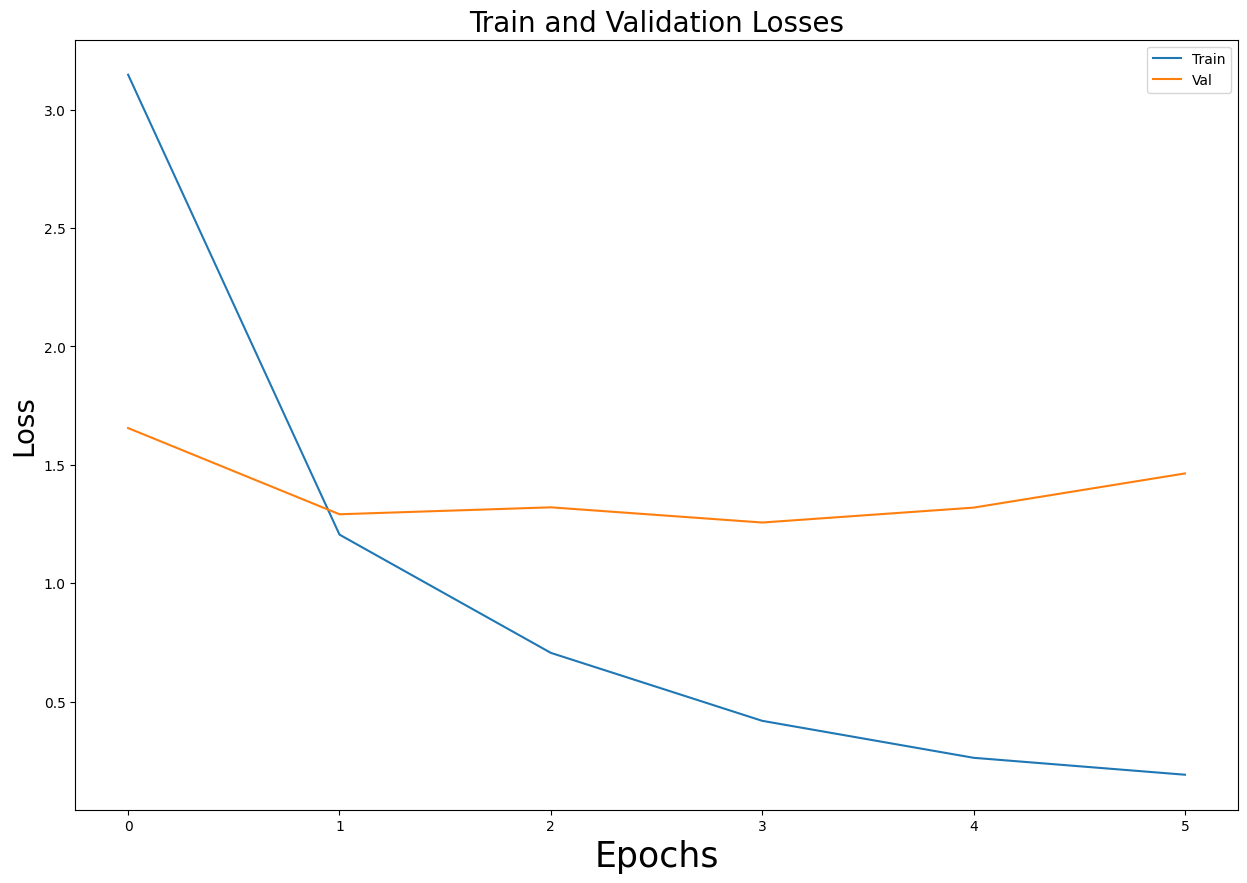

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')